In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3MB 45kB/s 
     |████████████████████████████████| 471kB 43.2MB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
     |████████████████████████████████| 2.9MB 38.9MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a5bdbe1c-0576-cf56-2e8f-4a3734970082)


In [ ]:
# Check TensorFlow version (should be 2.4.0+)
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-13 08:19:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-13 08:19:04 (107 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteW99ZYG/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteW99ZYG/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names

NameError: ignored

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 24
  Class name (str form): clam_chowder
        


In [ ]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[41, 32, 27],
        [43, 34, 29],
        [43, 34, 29],
        ...,
        [53, 50, 41],
        [48, 48, 38],
        [45, 45, 35]],

       [[40, 31, 26],
        [43, 34, 29],
        [45, 36, 31],
        ...,
        [46, 43, 34],
        [46, 46, 36],
        [49, 49, 39]],

       [[40, 31, 26],
        [44, 35, 30],
        [46, 37, 32],
        ...,
        [48, 45, 36],
        [48, 48, 40],
        [52, 52, 44]],

       ...,

       [[90, 78, 66],
        [93, 81, 69],
        [95, 83, 71],
        ...,
        [20,  8,  8],
        [20,  8,  8],
        [21,  9,  9]],

       [[93, 81, 69],
        [95, 83, 71],
        [96, 84, 72],
        ...,
        [21,  9,  9],
        [22, 10, 10],
        [23, 11, 11]],

       [[98, 86, 74],
        [99, 87, 75],
        [97, 85, 73],
        ...,
        [24, 12, 12],
        [26, 14, 14],
        [27, 15, 15]]], dtype=uint8)>

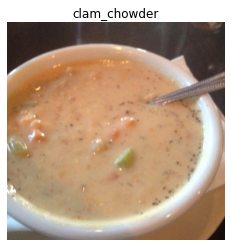

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[41 32 27]
  [43 34 29]
  [43 34 29]
  ...
  [53 50 41]
  [48 48 38]
  [45 45 35]]

 [[40 31 26]
  [43 34 29]
  [45 36 31]
  ...
  [46 43 34]
  [46 46 36]
  [49 49 39]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[42.05612  33.05612  28.056124]
  [42.09694  33.09694  28.09694 ]
  [43.64796  34.21939  29.433674]
  ...
  [64.80089  55.586624 46.586624]
  [50.622417 46.69386  37.69386 ]
  [47.02044  47.02044  37.02044 ]]

 [[44.760204 35.760204 30.760204]
  [46.066326 37.066326 32.066326]
  [49.357147 39.928574 35.14286 ]
  ...
  [64.33646  56.78038  48.62224 ]
  [53.836746 49.908188 40.908188]
  [52.015156 50.224434 42.821342]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


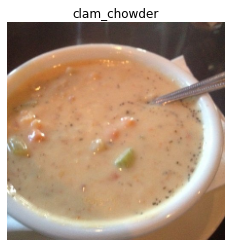

In [ ]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
data_augmentation=Sequential([
  preprocessing.RandomFlip("horizontal"), 
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomZoom(0.2),
])

In [ ]:
#Can't use because of Tensorflow Version 2.5.0
input_shape=(224,224,3)
# Create base model
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
#x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training=False) # set base_model to inference mode only

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
#Check the dtype policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb4 False <Policy "mixed_float16">
pooling_layer True <Policy "mixed_float16">
dense True <Policy "mixed_float16">
softmax_float32 True <Policy "float32">


In [ ]:
history_101_food_classes_feature_extract=model.fit(train_data,
                                                   epochs=3,
                                                   steps_per_epoch=len(train_data),
                                                   validation_steps=int(0.15*len(test_data)),
                                                   validation_data=test_data,
                                                   callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                          experiment_name="efficientb4_101_classes_all_data_feature_extract"),
                                                              model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientb4_101_classes_all_data_feature_extract/20210713-070255
Epoch 1/3
2368/2368 [==============================] - 263s 93ms/step - loss: 2.3216 - accuracy: 0.4562 - val_loss: 1.3349 - val_accuracy: 0.6496
Epoch 2/3
2368/2368 [==============================] - 214s 90ms/step - loss: 1.4101 - accuracy: 0.6352 - val_loss: 1.2300 - val_accuracy: 0.6719
Epoch 3/3
2368/2368 [==============================] - 213s 89ms/step - loss: 1.2288 - accuracy: 0.6792 - val_loss: 1.1857 - val_accuracy: 0.6939


In [ ]:
results_feature_extract_model=model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 65s 83ms/step - loss: 1.1879 - accuracy: 0.6834


[1.187861442565918, 0.6834059357643127]

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)


In [ ]:
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
#Not to forget 
# We are currently stopping because of colab gpu issue
#https://dev.mrdbourke.com/tensorflow-deep-learning/07_food_vision_milestone_project_1/

In [ ]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=3,
                                               verbose=1,
                                               min_lr=1e-7)

In [ ]:
for layer in model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs","efficientb4_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                    # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) 

Saving TensorBoard log files to: training_logs/efficientb4_101_classes_all_data_fine_tuning/20210713-071533
Epoch 1/100
2368/2368 [==============================] - 684s 279ms/step - loss: 1.0193 - accuracy: 0.7268 - val_loss: 0.7223 - val_accuracy: 0.7956
Epoch 2/100
2368/2368 [==============================] - 656s 276ms/step - loss: 0.3962 - accuracy: 0.8897 - val_loss: 0.7539 - val_accuracy: 0.7971
Epoch 3/100
2368/2368 [==============================] - 655s 276ms/step - loss: 0.1285 - accuracy: 0.9629 - val_loss: 0.9114 - val_accuracy: 0.7969
Epoch 4/100
2368/2368 [==============================] - 654s 276ms/step - loss: 0.0777 - accuracy: 0.9757 - val_loss: 0.8768 - val_accuracy: 0.8141

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.


In [ ]:
history=model.evaluate(test_data)

790/790 [==============================] - 65s 82ms/step - loss: 0.9338 - accuracy: 0.8068


In [ ]:
model